# Profile Vacancies recommendation engine

## Context

The notebook has been created in the context of a a "Postgraduate Studies in Big Data & Analytics in Business and Management". 

It has been based on the code snippets of jalajthanaki, which created the main part of the code.
https://github.com/jalajthanaki/Job_recommendation_engine 
I modified it a bit to cater for my own dataset.



## Importing libraries

In [91]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast 
import os
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.model_selection import train_test_split

import warnings; warnings.simplefilter('ignore')

## Load dataset

In [72]:
# Set the working dir
os.chdir(r'C:\Users\woutv\Jupyter\Jobs\inputdata')
# List the data
# os.listdir()

In [92]:
apps = pd.read_csv('./ProfielSolicitaties.csv', delimiter=';',encoding='utf-8')
jobs = pd.read_csv('./Vacatures.csv', delimiter=';',encoding='utf-8')
users = pd.read_csv('./ProfielenMetCV.csv' ,delimiter=';',encoding='utf-8')
# test_users = pd.read_csv('./inputdata/test_users.tsv', delimiter='\t',encoding='utf-8')

## Split training and testing data

* not used for now

In [7]:
apps_training, apps_testing = train_test_split(apps, test_size = 0.2)


## Checking some data

### Checking on how many times a vacancy had a profile or the other way around

In [165]:
apps['rating']=apps.apply(lambda row:1, axis=1)
apps.groupby(['VacatureId']).sum().sort_values(by=['rating'],ascending=False)


,ProfielSolicitatieId,ProfielId,SolicitatieStatus,Beantwoord,rating
VacatureId,,,,,
9445,1404593,1182649,0,False,153
7695,578500,542091,0,False,135
9356,1143345,1042224,0,False,129
12943,1736543,1593777,0,False,125
8709,721807,677130,0,False,119
9390,1078371,940941,0,False,118
12903,1609293,1361959,0,False,115
12891,1397133,1230204,0,False,102
5997,145571,132433,0,False,100


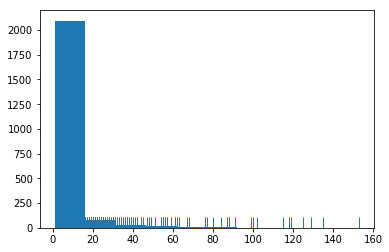

In [162]:
hist = apps.groupby(['VacatureId']).sum()

plt.hist(hist.rating, bins=10)
sns.rugplot(hist.rating);

In [166]:
apps.groupby(['ProfielId']).sum().sort_values(by=['rating'],ascending=False)


,ProfielSolicitatieId,VacatureId,SolicitatieStatus,Beantwoord,rating
ProfielId,,,,,
3424,100081,186794,0,False,28
6303,289502,236489,0,False,27
829,25887,143296,0,False,21
830,25074,144032,0,False,21
8800,155517,140243,0,False,16
1091,17148,109321,0,False,15
1124,36789,102327,0,False,15
2271,28578,77901,0,False,12
1826,21076,82208,0,False,11


## Approach 1


###  Look for similar jobs
Simple approach to get similar jobs

In [74]:
# check the columns of the document to see with what we can work.
jobs.columns


Index(['VacatureId', 'OrgineleId', 'Naam', 'Ref', 'Datum', 'Plaats',
       'Postcode', 'Type', 'Kantoor', 'Contactpersoon', 'Contactnummer',
       'Contactemail', 'Functie', 'Takenprofiel', 'Attesten', 'Vaardigheden',
       'Opleiding', 'Vakkennis', 'Ervaring', 'Talenkennis', 'Pckennis', 'Taal',
       'Duur', 'SolicitatieTypeStatus', 'FunctiegroepId', 'Database', 'Lat',
       'Lon', 'IsDeleted', 'IngaveDatum'],
      dtype='object')

In [93]:
# Concatenate different items which are relevant.
jobs['Naam'] = jobs['Naam'].fillna('')
jobs['Functie'] = jobs['Functie'].fillna('')
jobs['Takenprofiel'] = jobs['Takenprofiel'].fillna('')
jobs['NFT'] = jobs['Naam'] + jobs['Functie'] + jobs['Takenprofiel']

In [94]:
# Remove irrelevant words
from stop_words import get_stop_words
stops_words_dutch = get_stop_words('dutch')
stops_words_french = get_stop_words('french')
stops_words_df = stops_words_dutch + stops_words_french
# print(stops_words_df)
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words=stops_words_df)

# create a matrix with the word as features (columns) and the documents as rows. The values are the Tf-idf-weights
tfidf_matrix = tf.fit_transform(jobs['NFT'])
# print (tf.get_feature_names())
tfidf_matrix

<8356x133543 sparse matrix of type '<class 'numpy.float64'>'
	with 423368 stored elements in Compressed Sparse Row format>

In [95]:
# Calculating the cosine simularity of the corpus
# A nice explanation of how this works can be found here : 
# http://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)


In [96]:
cosine_sim[0]
jobs.index

RangeIndex(start=0, stop=8356, step=1)

In [100]:
# Creating a pandas serie which will hold a list with the names of the documents and the index. This index will be used to
# retrieve the index, based on the title of the job. This in its turn is then used to lookup documents in the cosine matrix
jobs = jobs.reset_index()
titles = jobs['Naam']
indices = pd.Series(jobs.index, index=jobs['Naam'])
# print(indices)

In [98]:
def get_recommendations(title):
    if title in indices:
        idx = indices[title]
        # Create an iteratable list from the matrix and getting the row that corresponds with the document. This row 
        # contains all comparisons for this document with the rest of the documents
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        job_indices = [i[0] for i in sim_scores]
        return titles.iloc[job_indices].head(10)
    else:
        return 'Not a known vacancy'

In [103]:
get_recommendations(13162)

8349    13162
2957     6776
5698     9517
6244    11057
8104    12917
8109    12922
8110    12923
8111    12924
8103    12916
8106    12919
Name: VacatureId, dtype: int64

In [18]:
get_recommendations('VENDEUR CONSEILLER')

8342                VENDEUR CONSEILLER
8222                VENDEUR AUTOMOBILE
1875                     VENDEUR (H/F)
2069      CONSEILLER VENDEUR OUTILLAGE
6955                      VENDEUR SHOP
424                 VENDEUR AUTOMOBILE
3178          VENDEUR AUTOMOBILE (H/F)
3833                       VENDEUR H/F
5359    CONSEILLER / VENDEUR ANIMALIER
6894    CONSEILLER / VENDEUR ANIMALIER
Name: Naam, dtype: object

In [19]:
get_recommendations('INFORMANT AUTOSALON 2019 - GENK')

8109            INFORMANT AUTOSALON 2019 - GENK
8110            INFORMANT AUTOSALON 2019 - BREE
8104          INFORMANT AUTOSALON 2019 - TIENEN
8111    INFORMANT AUTOSALON 2019 - SINT-TRUIDEN
8107    INFORMANT AUTOSALON 2019 - HERK-DE-STAD
8103         INFORMANT AUTOSALON 2019 - WEEKEND
8105         INFORMANT AUTOSALON 2019 - WEEKEND
8108         INFORMANT AUTOSALON 2019 - WEEKEND
8106           HOSTESS AUTOSALON 2019 - WEEKEND
8115                             INFORMANT (M/V
Name: Naam, dtype: object

## Approach 2

### Look for similar users
Find out similar users, based on content of the profile. Then check for which jobs they applied and present these jobs to the respective user.

In [167]:
# Only motivation contains some relevant information in the database.
#  users['Motivatie'] = users['Motivatie'].fillna('')
users['cvastext'] = users['cvastext'].fillna('')


In [168]:
# See above for more explanation.
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words=stops_words_df)
tfidf_matrix = tf.fit_transform(users['cvastext'])

In [169]:
tfidf_matrix.shape

(11361, 962113)

In [29]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [30]:
cosine_sim[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [171]:
users = users.reset_index()
userid = users['Id']
indices = pd.Series(users.index, index=users['Id'])

In [172]:
def get_recommendations_userwise(userid):
    idx = indices[userid]
    #print (idx)
    sim_scores = list(enumerate(cosine_sim[idx]))
    #print (sim_scores)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    user_indices = [i[0] for i in sim_scores]
    #print (user_indices)
    return user_indices[0:11]

In [173]:
print ("-----Top 10 Similar users with userId: 5------")
get_recommendations_userwise(7)


-----Top 10 Similar users with userId: 5------


[3, 7226, 4235, 6162, 4345, 3126, 5929, 4490, 2175, 2916, 1985]

In [174]:
def get_job_id(usrid_list):
    jobs_userwise = apps['ProfielId'].isin(usrid_list) #
    df1 = pd.DataFrame(data = apps[jobs_userwise], columns=['VacatureId'])
    joblist = df1['VacatureId'].tolist()
    Job_list = jobs['VacatureId'].isin(joblist) #[1083186, 516837, 507614, 754917, 686406, 1058896, 335132])
    df_temp = pd.DataFrame(data = jobs[Job_list], columns=['Naam','Takenprofiel','Postcode'])
    return df_temp

In [178]:
# Which job did he/she apply for?
userid = 3424
useridlist = [userid]
get_job_id(useridlist)

,Naam,Takenprofiel,Postcode
601,SAMENSTELLER LASSER,Deze firma werkt voor uiteenlopende industriet...,2320
1004,COMMERCIEEL BEDIENDE,-\tOpmaken offertes van de verschillende werfl...,2110
1059,MEDEWERKER PERSONEELSDIENST,Samen met een collega en in samenwerking met h...,2018
1232,COMMERCIEEL TECHNIEKER MET KENNIS VAN SANITAIR,U gaat naar onze klanten om reparaties en nazi...,2170
1241,BALIEMEDEWERKER - ADMINISTRATIEVE BEDIENDE,- Administratie voor verhuur van voertuigen: p...,2550
1352,TECHNISCH ADMINISTRATIEF MEDEWERKER,- Nederlandstalig met een zeer goede kennis Fr...,2570
1422,RECEPTIONIST(E),Voor een klant van ons Regio Edegem zijn wij o...,2650
1562,LOODGIETER,?Plaatsen van sanitaire installaties volgens d...,2330
1671,COMMERCIËLE BINNENDIENST VRACHTWAGEN ONDERDELEN,- Binnendienst verkoop voor ondersteuning exte...,2200
2860,MEUBELVERKOPER,* Helpen en adviseren van klanten in de keuze ...,2060


In [68]:
# Which job is recommended?
get_job_id(get_recommendations_userwise(userid))

,Naam,Takenprofiel,Postcode
3134,HOOFDAANKOPER EXTERIEUR,"Taken :\n\n-Onderhandelen met leveranciers, co...",9000
3135,INPAKKER,- je werkt mee aan de inpak waar nodig\n- je c...,2520
4380,MAGASINIER CARISTE,-Vous êtes en possession de votre brevet de ca...,6061
4648,JOBSTUDENT(E) BEDIENDE,We zijn op zoek naar een gemotiveerde bediende...,3670
4757,JOBSTUDENT GROOTHANDEL GROENTEN EN FRUIT M/V (...,Voor onze klant zoeken we studenten die in de ...,3500
5632,VENDEUR SANDWICHERIE,"Faire des sandwiches, \nPrendre des commandes,...",4040
5869,VENDEUR-CONSEILLER OUTILLAGE (H/F),"Vous serez en charge d'accueillir, conseillez ...",7110
